## Quantum Phase Estimation


### Period finding

Admit a function $f(x)$ from $n$-bit numbers to $m$-bit numbers. Consider $f(x)$ periodic of period $r$, meaning that $\forall x \in \{0,\cdots,N-r-1\}$, we have that $f(x) = f(x+r)$ and the values $f(x), f(x+1), \cdots, f(x+r-1)$ are all distinct. Suppose also that $ r \leq \sqrt{N}/2$


In a quantum algorithm, this function translates to an $n$-qubit input register and an $m$-qubit output register. We can prepare in the state:

$$ | \psi_0 \rangle = \frac{1}{\sqrt{N}} \sum_{x=0}^{2^n-1} | x\rangle |0\rangle$$

Using $n$ Hadamard gates.

We then apply a circuit that performs the unitary $\hat{U}_f$:

$$\hat{U}_f | \psi_0 \rangle =\frac{1}{\sqrt{N}} \sum_{x=0}^{2^n-1} | x\rangle | f(x) \rangle$$

If we measure the output register _only_, we get a particular value $a$. The input register will be left in an evenly-weighted superposition of all $x$ such that $f(x) = a$:

$$\frac{1}{\sqrt{N/r}} \sum_{n=0}^{N/r-1} |x_0 + nr \rangle | a \rangle$$

From now on, we will ignore the output register since the measurement has fixed its state.

If we apply the QFT to the input register, we will gate a state in the form:

$$\sum_{m=0}^{r-1} \alpha_m |m N/r\rangle$$

If we now measure the input register, we would get one value $mN/r$, for some random $m$ between $0$ and $r-1$.

* This is not enough to tell us the value of $N/r$, but if we run the algorithm $d$ times, we will get a sequence of integers $m_1 N/r, \cdots, m_d N/r$ which are all multiples of $N/r$.

* For a sufficiently large number of runs $d$ (which grows moderately in $N$) we can be confident that, with high probability, $N/r$ is the only common factor of all the numbers.

The greatest common factor between two numbers can be found, for example, using the [Euclidian algorithm](https://en.wikipedia.org/wiki/Euclidean_algorithm).

In [1]:
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, compile

from qiskit.tools import visualization
from qiskit.tools.visualization import circuit_drawer, plot_histogram

from math import pi
import matplotlib.pyplot as plt

In [2]:

# Plot results
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim, shots=1000)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)

In [3]:
def qftransform (circuit, qr, swap = True):

    n = qr.size
    for i in range(n-1, 0, -1):
        circuit.barrier()
        circuit.h(qr[i])
        for j in range (i-1, -1, -1):
            r = 2**(i-j+1)
            circuit.cu1((2*pi/r), qr[j], qr[i])
    circuit.barrier()
    if swap == True and n > 1:
        for i in range(0, n//2):
            circuit.swap(qr[i], qr[n-i-1])

**Task**: Using the technique detailed above, find the period of the function $f:\{0,1\}^3 \rightarrow \{0,1\}^3$ below.

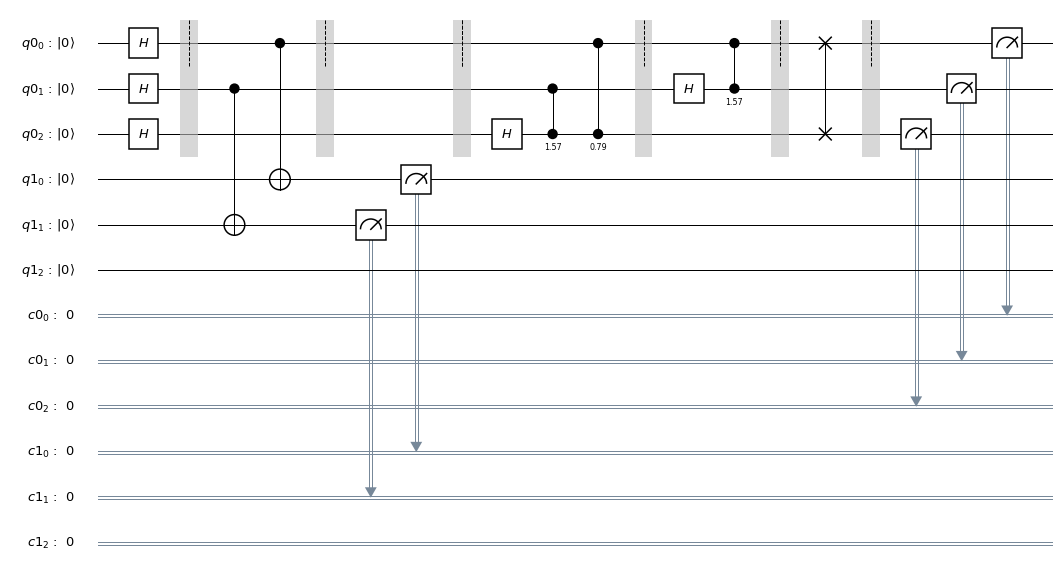

In [4]:
    # Print the results
    # Print the results
qin = QuantumRegister(3)
qout = QuantumRegister(3)
cin = ClassicalRegister(3)
cout = ClassicalRegister(3)
qc = QuantumCircuit(qin, qout, cin, cout)

qc.h(qin)



qc.barrier()


qc.cx(qin[0],qout[0])
qc.cx(qin[1],qout[1])

qc.barrier()
qc.measure(qout[0],cout[0])
qc.measure(qout[1],cout[1])

qc.barrier()
qftransform(qc,qin)
qc.barrier()
qc.measure(qin,cin)



qc.draw(output='mpl')

simulation: 

 {'000 000': 137, '000 010': 122, '011 100': 139, '001 100': 118, '011 110': 123, '001 110': 121, '010 010': 126, '010 000': 114}


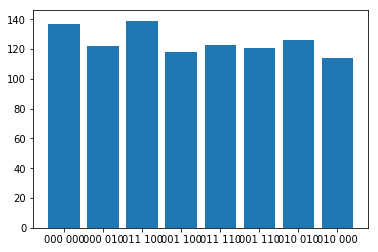

In [17]:
execute_locally(qc)

We can see how the quantum Fourier transform made it possible to find the period of a function by repeated measurements and the greatest common divisor (GCD) algorithm.

## Phase estimation

The phase estimation algorithm is a solution to a rather specific problem. However, similarly to the QFT and Grover's search algorithm, it turns out to be useful as a building block to several other algorithms to solve more general and important problems.

Suppose we have a unitary operator $\hat{U}$ operating on $n$-qubits, with a known eigenstate$^1$ $| u \rangle$ and an associated unknown eigenvalue $e^{i\phi}$, where $0 \leq \phi < 2\pi$. We want to find the eigenvalue, which means finding phase $\phi$ with $m$-bits of precision.


We might try to prepare $n$ qubits in the state $|u\rangle$ and carry out the unitary transformation $\hat{U}$ on them:


<img src="img/pe1.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="400 px" align="center"> 


$^1$: An eigenstate is a quantum mechanical state whose wave function is an eigenvector that corresponds to a physical quantity.

**Question**: is there a measurement on the bits which will give us information about the phase $\phi$?



Before we look into a more sophisticated approach to the problem, it's important to understand **phase kickback**.

### Phase kickback

A key part of understanding the phase kickback is that $|\psi\rangle$ is an eigenvector of the operator $U$ with an eigenvalue of $e^{2\pi i \phi}$. In other words, $U|\psi\rangle = e^{2\pi i \phi}|\psi\rangle$, where $\phi$ is the phase that we are interested in 'kicking back'. A small example:

<img src="img/pk1.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="center"> 

At point A, the system's state is simply $|0\rangle|\psi\rangle$. 

By point B, the Hadamard operator has converted $|0\rangle$ into $H|0\rangle = |+\rangle = \frac{|0\rangle+|1\rangle}{\sqrt{2}} $. Thus, at point B, the whole system is in the state $\frac{|0\rangle+|1\rangle}{\sqrt{2}}|\psi\rangle = \frac{|0\rangle|\psi\rangle+|1\rangle|\psi\rangle}{\sqrt{2}}$. 

Between points B and C, a controlled $U$ operator is applied.

Thus, at point C, the system is in the state $\frac{|0\rangle|\psi\rangle+|1\rangle U|\psi\rangle}{\sqrt{2}} = \frac{|0\rangle|\psi\rangle+|1\rangle e^{2\pi i \phi}|\psi\rangle}{\sqrt{2}} = $
$\frac{|0\rangle+e^{2\pi i \phi}|1\rangle}{\sqrt{2}}|\psi\rangle$.

Note how the state $|\psi\rangle$ remains unchanged. This happens because applying $\hat{U}$ to $|\psi \rangle$ results in a "multiple" $e^{2\pi i \phi}$ gets of $|\psi \rangle$, which can be factored out. **This is only possible since we admit that $|\psi\rangle$ is an eigenstate of $\hat{U}$**.

Now, let's consider higher powers of $U$, e.g. $U^2$. 

In this case, $|\psi\rangle$ is still an eigenvector of $U^2$ - this is because $U^2|\psi\rangle = U(U|\psi\rangle) = e^{2\pi i \phi}U(|\psi\rangle) = e^{2*2\pi i \phi} |\psi\rangle$
More generally, $U^x |\psi\rangle = e^{2x\pi i \phi}|\psi\rangle$ . 

In other words, an eigenvector of $U$ is also an eigenvector of $U^x$; just with an eigenvalue that is raised to the power $x$.

**Task:** 

Analyse the following circuit and write the expressions for the quantum state at points B and C.

<img src="img/pk2.png" width="500 px" align="center"> 


Answer: 


### Phase estimation algorithm

The first part of the phase estimation algorithm consists in a paralell application of the phase kickback technique detailed above, to successive powers of $U$:

<img src="img/pk3.png" width="500 px" align="center"> 

The complete phase estimation procedure is as follows:

1. Prepare the $t$-bit control register in state $|0 \rangle$, and the target register in state $|u\rangle$ (eigenstate of $U$);

2. Perform Hadamards on the control bits.

3. Apply a controlled-$\hat{U}^{2^j}$, from the $j$th control bit onto the n target bits for each of the control q-bits in succession.

4. Perform an **inverse** Fourier transform on the $t$ control bits and measure them in the computational basis. The measured bit values $\phi_1, \cdots, \phi_2$ give an estimate of the phase $\phi \approx 0.\phi_1 \cdots \phi_2$.

In [18]:
def qftransforminv (circuit,qr,swap=True):
    n=qr.size
    i=0
    j=0
    while i<n:
      
        k=2
        j=0
        circuit.barrier()
        while j<i:
            circuit.cu1(2*pi/(2**k),qr[i],qr[j])
            k+=1
            j+=1
        circuit.h(qr[i])
        i+=1
    circuit.barrier()
    if(swap):
        i=0
        j=n-1
        while i<(n//2):
            circuit.swap(qr[i],qr[j])
            i+=1
            j-=1
            
    
    return  circuit

In [5]:

<



SyntaxError: invalid syntax (<ipython-input-5-9d602bf67f32>, line 2)

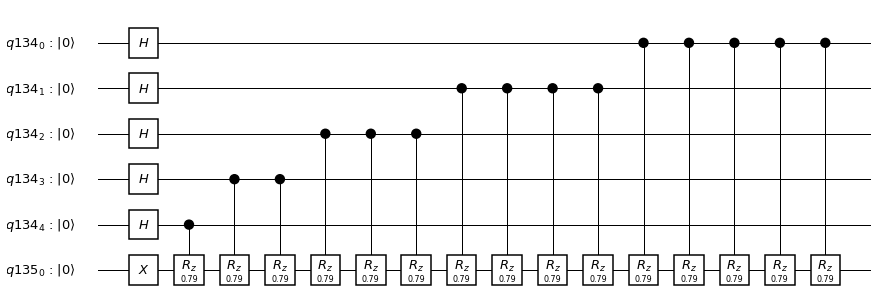

In [79]:
    # Print the results
N=5
qin = QuantumRegister(N)

qout = QuantumRegister(1)

qc = QuantumCircuit(qin, qout)

qc.x(qout)
qc.h(qin)


n=N-1
j=0
i=0

while n>=0:
    qc.crz(pi/4, qin[n], qout)
    while j>0:
        qc.crz(pi/4, qin[n], qout)
        j-=1
        
    n-=1
    i+=1
    j=i


qc.draw(output='mpl')